In [19]:
# import useful libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score
import joblib



# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import helper functions

In [20]:
data_folder = 'data'


def get_dataframes():
    train_X = pd.read_csv('../' + data_folder + '/' + 'train_X.csv')
    train_Y = pd.read_csv('../' + data_folder + '/' + 'train_y.csv')
    test_X = pd.read_csv('../' + data_folder + '/' + 'test_X.csv')
    test_Y = pd.read_csv('../' + data_folder + '/' + 'test_y.csv')
    return train_X, train_Y, test_X, test_Y


# import the test and train dataframes
train_X, train_Y, test_X, test_Y = get_dataframes()

train_X.info()

# # take just first 10000 rows for training
# train_X = train_X[:1000]
# train_Y = train_Y[:1000]

# # take just first 1000 rows for testing
# test_X = test_X[:200]
# test_Y = test_Y[:200]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140398 entries, 0 to 140397
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   heartrate         140398 non-null  float64
 1   handTemperature   140398 non-null  float64
 2   handAcc16_1       140398 non-null  float64
 3   handAcc16_2       140398 non-null  float64
 4   handAcc16_3       140398 non-null  float64
 5   handAcc6_1        140398 non-null  float64
 6   handAcc6_2        140398 non-null  float64
 7   handAcc6_3        140398 non-null  float64
 8   handGyro1         140398 non-null  float64
 9   handGyro2         140398 non-null  float64
 10  handGyro3         140398 non-null  float64
 11  handMagne1        140398 non-null  float64
 12  handMagne2        140398 non-null  float64
 13  handMagne3        140398 non-null  float64
 14  chestTemperature  140398 non-null  float64
 15  chestAcc16_1      140398 non-null  float64
 16  chestAcc16_2      14

In [21]:
# import the required libraries

# for specific c values

validation_k = 5
validation_scores = {}
c_values = [0.001, 0.01, 0.1, 1.0]
accuracies = []


def logistic_regression(is_validation=False, is_test=False):
    best_accuracy = 0
    best_weights = []
    best_c = 0
    if is_validation:
        train_scores, test_scores = validation_curve(
            LogisticRegression(), train_X, train_Y, param_name='C', param_range=c_values, cv=validation_k, scoring='accuracy')
        train_scores = np.mean(train_scores, axis=1)
        test_scores = np.mean(test_scores, axis=1)

        print("Validation scores for C = ", c_values)
        print("Train scores: ", train_scores)
        print("Test scores: ", test_scores)
        validation_scores = {'train': train_scores, 'test': test_scores}
        return validation_scores
    for c in c_values:
        log_reg = LogisticRegression(solver='sag',
                                     multi_class='multinomial',
                                     max_iter=5000, random_state=42, C=c)

        if is_test:
            log_reg.fit(train_X, train_Y)
            y_pred = log_reg.predict(test_X)
            acc = accuracy_score(test_Y, y_pred)
            print('Accuracy for C = ', c, ' is ', acc)
            accuracies.append(acc)
            if acc > best_accuracy:
                best_accuracy = acc
                best_c = c
                best_weights = log_reg.coef_
                # save the model
                joblib.dump(log_reg, '../models/logistic_regression.joblib')

    return best_accuracy, best_weights, best_c


# store the best weights in a csv file in the models folder
best_accuracy, best_weights, best_c = logistic_regression(is_test=True)
np.savetxt('../models/best_weights_logistic.csv', best_weights, delimiter=',')
print('Optimal C value is 0.01')
print('Accuracy: ', accuracies[1])


Accuracy for C =  0.001  is  0.7925925925925926
Accuracy for C =  0.01  is  0.8014814814814815
Accuracy for C =  0.1  is  0.8049287749287749
Accuracy for C =  1.0  is  0.8065527065527065
Optimal C value is 0.01
Accuracy:  0.8014814814814815


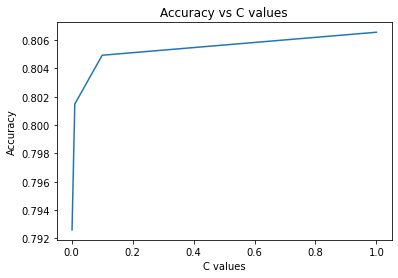

In [22]:
# plot the accuracies
plt.plot(c_values, accuracies)
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C values')
plt.show()



Validation scores for C =  [0.001, 0.01, 0.1, 1.0]
Train scores:  [0.74999466 0.7508654  0.75013177 0.74813566]
Test scores:  [0.74917737 0.75055915 0.74956198 0.74774571]


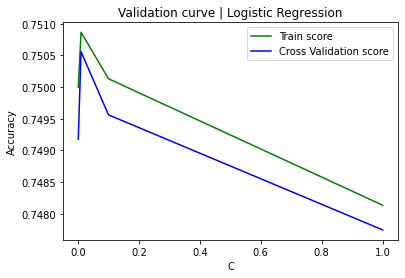

In [23]:
# plotting the validation scores

validation_scores = logistic_regression(is_validation=True)
plt.plot(c_values, validation_scores
         ['train'], color='green', label='Train score')
plt.plot(c_values, validation_scores
         ['test'], color='blue', label='Cross Validation score')
plt.title('Validation curve | Logistic Regression')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


In [24]:
# best model is loaded and used to predict the output
def predict_output(test_X):
    log_reg = joblib.load('../models/logistic_regression.joblib')
    pred = log_reg.predict(test_X)
    # get the accuracy
    acc = accuracy_score(test_Y, pred)
    print('Accuracy for the test data from loaded model is: ', acc)
    return pred

predict_output(test_X)

Accuracy for the test data from loaded model is:  0.8065527065527065


array([ 4, 17,  7, ...,  4,  3,  3], dtype=int64)